# Moving Averge Trading Strategy 

In [7]:
# This strategy involves opening long positions based on the crossover of  SLOW & FAST:SMA (Simple moving Average). 
# When SLOW SMA (calculated based on longer period of past observatios) crosses FAST SMA (Calcuated based on fewer past observations),
# & SLOW SMA is below FAST SMA, we then open long positions (on a stock) since it is generally characterised by bullish maket condition.
# We close this long position in next cross over of these SMA's, when Fast SMA is below slow SMA  

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

C:\Users\Tushar Chandel\Desktop\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


[*********************100%%**********************]  1 of 1 completed


Columns available in data: Index(['Price', 'Short EMA', 'Long EMA'], dtype='object')


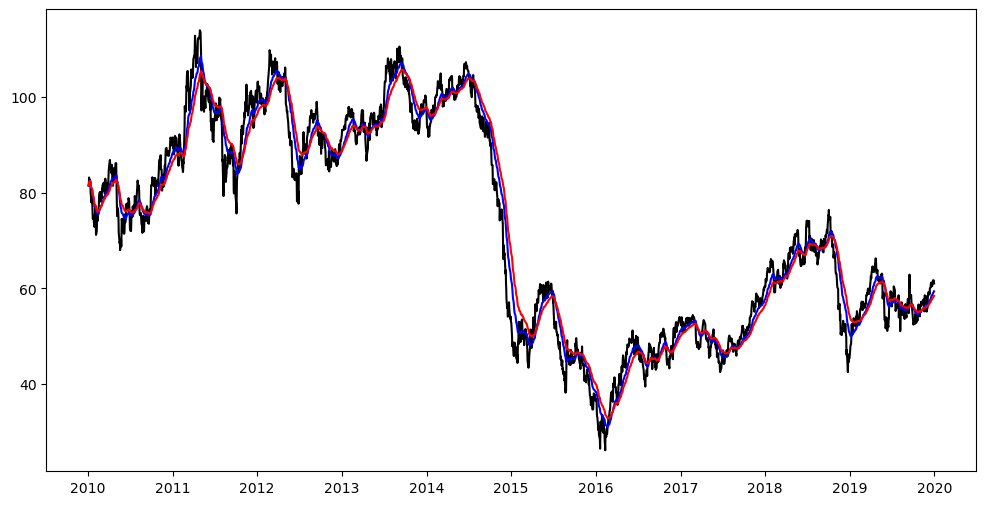

Trading profit: -9.64%
Capital At the end: $90.36


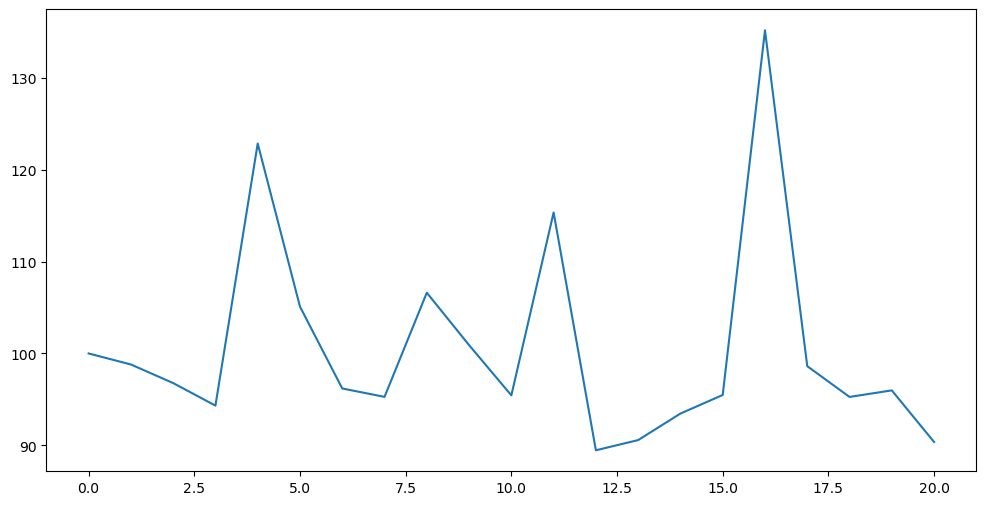

In [2]:
class MovingAverage:
    def __init__(self, capital, stock, start, end, short_period, long_period):
        self.data = None
        self.is_long = False
        self.short_period = short_period
        self.long_period = long_period
        self.capital = capital
        self.equity = [capital]
        self.stock = stock
        self.start = start
        self.end = end
    
    def sim(self):
        # considering whether to open a long position or not
        price_when_buy = 0 
        
        for index, row in self.data.iterrows():
            if row['Short EMA'] < row['Long EMA'] and self.is_long:
                self.equity.append(self.capital * row.Price / price_when_buy)
                self.is_long = False
              
            elif row['Short EMA'] > row['Long EMA'] and not self.is_long:
                # In this condition, open a long position
                price_when_buy = row['Price']
                self.is_long = True
                

    def download_data(self):
        stock_data = {}
        ticker = yf.download(self.stock, self.start, self.end)
        stock_data['Price'] = ticker['Adj Close']
        self.data = pd.DataFrame(stock_data)

    def Short_Long_MA(self):
        self.data['Short EMA'] = self.data['Price'].ewm(span=self.short_period).mean()
        self.data['Long EMA'] = self.data['Price'].ewm(span=self.long_period).mean()

    def graph_MA(self):
        if self.data is None:
            print("Data not available. Call download_data() first.")
            return

        print("Columns available in data:", self.data.columns)
        
        plt.figure(figsize=(12, 6))
        plt.plot(self.data['Price'], color='black')
        plt.plot(self.data['Short EMA'], color='blue')
        plt.plot(self.data['Long EMA'], color='red')
        plt.show()
        
    def profit(self):
        print('Trading profit: %.2f%%'  %( (float(self.equity[-1])-float(self.equity[0]))/
                                 float(self.equity[0])*100))
        print('Capital At the end: $%0.2f' % self.equity[-1])
        plt.figure(figsize=(12, 6))
        plt.plot(self.equity)
        plt.show()

if __name__ == '__main__':
    start_date = datetime.datetime(2010, 1, 1)
    end_date = datetime.datetime(2020, 1, 1)

    stma = MovingAverage(100, 'CL=F', start_date, end_date, 30, 50)
    stma.download_data()
    stma.Short_Long_MA()
    stma.graph_MA()
    stma.sim()
    stma.profit()


In [ ]:
#The above strategy is usally not profitable, since it is so simple that it is not able to explain the correlation
# between the given observations

# Momentum & Moving Avrgage (SMA) combined Trading Strategy 

In [ ]:
# In this straategy, we combine the  Moving Avrgage indicator (SMA) & momentum strategy together to get better results. 
#  we first select an index (such as nasdaq or S&P 500), compute its SMA (SLOW)
# Trades will be initiated when the index is above its SMA, indicating bullish market conditions.
# We will then rank all the commodities in the given index based on their highest momentum (based on last 90-100 days of data)
 #i.e rank  commodities which outperformed in the recent past and whose price we expect to rise
# Based on the given rank, we open long positions on commodity futures that are in the top 20% momentum range based on the above SMA condition. 
# Similarly, we close the long positions that are not in the top 20% momentum range.
# The size of these positions would primarily depend on the average true range (ATR) 
#indicator which measures the volatility of the given assets.
# .Finally to adapt to changing market conditions, positions will be rebalanced and updated every 2 weeks,
# ensuring alignment with current momentum trends and risk profiles. 


In [6]:
import yfinance as yf
import backtrader as bt
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import os


def calculate_momentum(data):
    data_slice = data.copy()
    data_slice[data_slice <= 0] = np.nan  # Replace non-positive values with NaN
    log_data = np.log(data_slice)
    x_data = np.arange(len(log_data))
    beta, _, rvalue, _, _ = linregress(x_data, log_data)
    # we have to annualize the slope
    # there are 252 trading days in a year
    return ((1+beta)**252) * (rvalue**2)


class Momentum(bt.Indicator):
    # every trading day has a momentum parameter
    # except for the first 90 days
    lines = ('momentum_trend',)
    params = (('period', 90),)

    def __init__(self):
        self.addminperiod(self.params.period)

    def next(self):
        data_slice = np.array(self.data.get(size=self.params.period))  # Convert to NumPy array
        data_slice[data_slice <= 0] = np.nan  # Replace non-positive values with NaN
        returns = np.log(data_slice)
        x = np.arange(len(returns))
        beta, _, rvalue, _, _ = linregress(x, returns)
        annualized = (1 + beta) ** 252
        self.lines.momentum_trend[0] = annualized * rvalue ** 2


class MomentumStrategy(bt.Strategy):

    def __init__(self):
        self.counter = 0
        self.indicators = {}
        self.sorted_data = []
        # we store the SP500 (this is the index) data as the first item of the dataset
        self.spy = self.datas[0]
        # all the other stocks (present in SP500)
        self.stocks = self.datas[1:]

        for stock in self.stocks:
            self.indicators[stock] = {}
            self.indicators[stock]['momentum'] = Momentum(stock.close, period=90)
            self.indicators[stock]['sma100'] = bt.indicators.\
                SimpleMovingAverage(stock.close, period=100)
            self.indicators[stock]['atr20'] = bt.indicators.ATR(stock, period=20)

        # SMA for SP500 index - because we open long positions when the SP500 index
        # is above it's SMA(200) BULLISH MARKET
        self.sma200 = bt.indicators.MovingAverageSimple(self.spy.close, period=200)

    def prenext(self):
        # count the number of days elapsed
        self.next()

    def next(self):
        # a week has passed so we have to make trades
        if self.counter % 5 == 0:
            self.rebalance_portfolio()
        if self.counter % 10 == 0:
            # 2 weeks have passed
            self.update_positions()

        self.counter += 1

    def rebalance_portfolio(self):

        self.sorted_data = list(filter(lambda stock_data: len(stock_data) > 100, self.stocks))
        # sort the SP500 stocks based on momentum
        self.sorted_data.sort(key=lambda stock: self.indicators[stock]['momentum'][0])
        num_stocks = len(self.sorted_data)

        # sell stocks (close the long positions) - top 20%
        for index, single_stock in enumerate(self.sorted_data):
            # we can check whether are there open positions
            if self.getposition(self.data).size:
                # if the stock is not in the top 20% then close the long position
                # sell the stock if it's price falls below its 100 days MA
                if index > 0.2 * num_stocks or single_stock < self.indicators[single_stock]['sma100']:
                    self.close(single_stock)

        # we open long positions when the SMA is below the SP500 index
        if self.spy < self.sma200:
            return

        # consider the top 20% of the stocks and buy accordingly
        for index, single_stock in enumerate(self.sorted_data[:int(0.2 * num_stocks)]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash > 0 and not self.getposition(self.data).size:
                size = value * 0.001 / self.indicators[single_stock]["atr20"]
                self.buy(single_stock, size=size)

    def update_positions(self):
        num_stocks = len(self.sorted_data)

        # top 20% momentum range
        for index, single_stock in enumerate(self.sorted_data[:int(0.2 * num_stocks)]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash > 0:
                size = value * 0.001 / self.indicators[single_stock]["atr20"]
                self.order_target_size(single_stock, size)


if __name__ == '__main__':
    stocks = []
    cerebro = bt.Cerebro()

    folder_path = 'C:/Users/Tushar Chandel/OneDrive/Desktop/KKLA'  # Adjust this path according to your folder structure

    filename = input("Enter the name of the file containing the list of companies: ")

    with open(filename) as file_in:
        for line in file_in:
            company_name = line.strip('\n')
            csv_file_path = os.path.join(folder_path, f"{company_name}.csv")
            if os.path.isfile(csv_file_path):
                stocks.append(company_name)
                try:
                    df = pd.read_csv(csv_file_path, parse_dates=True, index_col=0)
                    if len(df) > 100:
                        cerebro.adddata(bt.feeds.PandasData(dataname=df, plot=False))
                except FileNotFoundError:
                    pass

    cerebro.addobserver(bt.observers.Value)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    # this is how we attach the strategy we have implemented
    cerebro.addstrategy(MomentumStrategy)

    cerebro.broker.set_cash(100000)
    
    

    print('Initial capital: $%.2f' % cerebro.broker.getvalue())
    results = cerebro.run()

    print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
    print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
    print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")
    print('Capital at end: $%.2f' % cerebro.broker.getvalue())


Enter the name of the file containing the list of companies: C:\Users\Tushar Chandel\OneDrive\Desktop\TYU.txt
Initial capital: $100000.00
Sharpe: 0.112
Norm. Annual Return: 0.69%
Max Drawdown: 43.58%
Capital at end: $107138.62
